In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import glob
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize, ToTensor, Compose
from torchvision import models
import os
import natsort
from PIL import Image
from torch.utils.data import SubsetRandomSampler, Subset, ConcatDataset
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from albumentations import (
    HorizontalFlip, ShiftScaleRotate, RandomRotate90,
    Cutout, Flip, OneOf, Compose
)
import pandas as pd
import numpy as np
import albumentations as A
# You may add any imports you need

In [ ]:
!tar -xvf '/content/drive/MyDrive/IDAO/track_1.tar.gz' -C '/content/drive/MyDrive/IDAO'

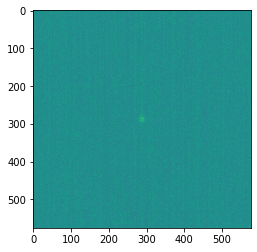

In [3]:
file = np.random.choice(glob.glob("/content/drive/MyDrive/IDAO/idao_dataset/train/*/*.png"))
plt.imshow(plt.imread(file))
plt.show()

In [3]:
root = '/content/'

In [4]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, class_df, root=root, transform=None):

        self.data_dir = data_dir
        self.root = root
        self.class_df = class_df
        self.transform = transform
        self.image_paths = [(f'{root}{data_dir}/{path}',
                             class_df[class_df['name']==path]['energy'].item()) 
                            for path in os.listdir(f'{root}{data_dir}')]
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx][0]).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return (img, self.image_paths[idx][1])
    def __len__(self):
        return len(self.image_paths)

In [5]:
def train(model, train_dataloader, eval_dataloader, criterion ,optimizer, device, epochs, scheduler):
  model.to(device)
  loss = criterion
  best_loss = []
  best_accuracy = []
  for_plot_x = []
  for_plot_y = []
  for_plot_x_test = []
  for_plot_y_test = []
  for_plot_x_test1 = []
  for_plot_y_test1 = []
  for_plot_x1 = []
  for_plot_y1 = []
  all_test = 0
  k = 0
  model.train()
  for epoch in range(epochs):
      current_loss = 0
      current_loss1 = 0
      right_answers = 0
      all_answers = 0
      i = 0
      loss_test = 0
      cnt_test = 0
      for batch in tqdm(train_dataloader):
          imgs, cls = batch
          imgs, cls = imgs.to('cuda'), cls.to('cuda')
          optimizer.zero_grad()
          y_pred = model(imgs)
          output = loss(y_pred, cls)
          output.backward()
          optimizer.step()

          values, indicies  = y_pred.max(axis =1)
          right_answers = ((indicies - cls)==0).sum().item()
          all_answers = len(indicies)
          current_accuracy = right_answers/all_answers
          current_loss += output.item()
          current_loss1 += output.item()
          if i % 10 == 9:
                for_plot_x.append(k + (i+1))
                for_plot_y.append(current_loss1/10)
                for_plot_x1.append(k + (i+1))
                for_plot_y1.append(current_accuracy)
                current_loss1 = 0
          if i % 10 == 9:
                print('[{},{}], loss_train:{}, accuracy_train:{}'.format(epoch + 1, i + 1, current_loss/10, current_accuracy ))
                current_loss = 0
                
          
          i+=1
      k +=i
      model.eval()
      with torch.no_grad():
        accuracy_list = []
        for batch in eval_dataloader:
          imgs, cls = batch
          imgs, cls = imgs.to('cuda'), cls.to('cuda')
          y_pred = model(imgs)
          values, indicies  = y_pred.max(axis =1)
          accuracy = accuracy_score(indicies.to('cpu').numpy(),cls.to('cpu').numpy())
          accuracy_list.append(accuracy)
          output1 = loss(y_pred, cls)
          loss_test += output1.item()
          cnt_test += 1
        for_plot_y_test1.append(np.array(accuracy_list).mean())
        for_plot_x_test1.append(k)
        for_plot_x_test.append(k)
        for_plot_y_test.append(loss_test/cnt_test)
      clear_output()
      scheduler.step()
      fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
      ax[0].scatter(for_plot_x, for_plot_y)
      ax[0].scatter(for_plot_x_test,for_plot_y_test, s = 10**2)
      ax[0].set_title('Loss')
      ax[0].set_xlabel('Step number')
      ax[0].set_ylabel('Loss')
      ax[0].legend(('train', 'evaluation'), loc='upper right', shadow=True)
      ax[1].scatter(for_plot_x1, for_plot_y1)
      ax[1].scatter(for_plot_x_test1,for_plot_y_test1, s = 10**2)
      ax[1].set_title('Accuracy')
      ax[1].set_xlabel('Step number')
      ax[1].set_ylabel('Accuracy')
      ax[1].legend(('train', 'evaluation'), loc='lower right', shadow=True)
      plt.show()
      print('Loss last batch train:{}'.format(output.item()))
      print('Loss_evaluation:{}'.format(loss_test/cnt_test))
      print('Accuracy last batch train:{}'.format(current_accuracy))
      print('Accuracy_evaluation:{}'.format(np.array(accuracy_list).mean()))

In [6]:
def predict(model, val_dataloader, criterion, device="cuda:0"):
      model.eval()
      losses = []
      predicted_classes = []
      true_classes = []
      with torch.no_grad():
        for batch in tqdm(val_dataloader):
          imgs, cls = batch
          imgs, cls = imgs.to(device), cls.to(device)
          y_pred = model(imgs)
          values, indicies  = y_pred.max(axis =1)
          predicted_classes.append(indicies)
          true_classes.append(cls)
          output = criterion(y_pred, cls)
          losses.append(output.item())
      predicted = []
      true = []
      for i in tqdm(predicted_classes):
        for j in i:
          predicted.append(j.to('cpu'))
      for n in true_classes:
        for k in n:
          true.append(k.to('cpu'))
      return losses, predicted, true

#Типы частиц

In [27]:
transforms= torchvision.transforms.Compose([Resize(224),
                           ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ])

In [28]:
dataset = ImageFolder(root= "/content/drive/MyDrive/IDAO/idao_dataset/train/", transform=transforms)
val_dataset = Subset(dataset, indices=np.arange(0, len(dataset), 14))
train_dataset= Subset(dataset, indices=np.delete(np.arange(0, len(dataset), 1), np.arange(0, len(dataset), 14)))
sampler = SubsetRandomSampler(torch.randperm(len(train_dataset)))
sampler1 = SubsetRandomSampler(torch.randperm(len(val_dataset)))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, sampler = sampler )
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 8 , sampler = sampler1)

In [29]:
model = models.resnext101_32x8d(pretrained=True)
for param in model.parameters():
   param.requires_grad = False
model.fc = nn.Sequential(nn.Linear(2048,2))
for param in model.fc.parameters():
        param.requires_grad = True
for param in model.layer4.parameters():
        param.requires_grad = True
for param in model.layer3.parameters():
        param.requires_grad = True
for param in model.layer2.parameters():
        param.requires_grad = True

In [30]:
optimizer = torch.optim.SGD([{'params': model.fc.parameters()},
                {'params': model.layer4.parameters(), 'lr': 1e-4}, 
                {'params': model.layer3.parameters(), 'lr': 1e-4},
                {'params': model.layer2.parameters(), 'lr': 1e-4},
                {'params': model.layer1.parameters(), 'lr': 1e-5},
            ], lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lmbda = lambda epoch: 0.5
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
n_epochs = 1
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

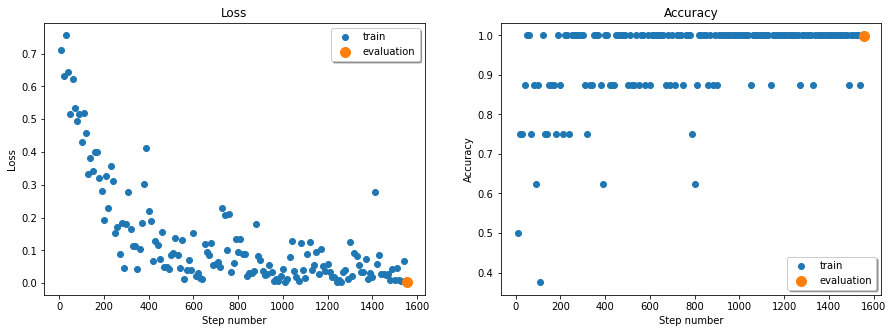

Loss last batch train:0.018479323014616966
Loss_evaluation:0.004671796205426896
Accuracy last batch train:1.0
Accuracy_evaluation:0.9989583333333333


In [31]:
train(model, train_dataloader, val_dataloader, criterion ,optimizer, device, n_epochs, scheduler)

#Типы энергии регрессия

In [8]:
def train1(model, train_dataloader, eval_dataloader, criterion ,optimizer, device, epochs, scheduler):
  model.to(device)
  loss = criterion
  best_loss = []
  best_accuracy = []
  for_plot_x = []
  for_plot_y = []
  for_plot_x_test = []
  for_plot_y_test = []
  for_plot_x_test1 = []
  for_plot_y_test1 = []
  for_plot_x1 = []
  for_plot_y1 = []
  all_test = 0
  k = 0
  model.train()
  for epoch in range(epochs):
      current_loss = 0
      current_loss1 = 0
      right_answers = 0
      all_answers = 0
      i = 0
      loss_test = 0
      cnt_test = 0
      for batch in tqdm(train_dataloader):
          imgs, cls = batch
          imgs, cls = imgs.to('cuda'), cls.to('cuda')
          optimizer.zero_grad()
          y_pred = model(imgs)
          output = loss(y_pred.type(torch.DoubleTensor).to('cuda') , cls)
          output.backward()
          optimizer.step()
          current_loss += output.item()
          current_loss1 += output.item()
          if i % 10 == 9:
                for_plot_x.append(k + (i+1))
                for_plot_y.append(current_loss1/10)
                current_loss1 = 0
          if i % 10 == 9:
                print('[{},{}], loss_train:{}'.format(epoch + 1, i + 1, current_loss/10))
                current_loss = 0
                
          
          i+=1
      k +=i
      model.eval()
      with torch.no_grad():
        accuracy_list = []
        for batch in eval_dataloader:
          imgs, cls = batch
          imgs, cls = imgs.to('cuda'), cls.to('cuda')
          y_pred = model(imgs)
          output1 = loss(y_pred, cls)
          loss_test += output1.item()
          cnt_test += 1
        for_plot_x_test.append(k)
        for_plot_y_test.append(loss_test/cnt_test)
      clear_output()
      scheduler.step()
      fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,5))
      ax.scatter(for_plot_x, for_plot_y)
      ax.scatter(for_plot_x_test,for_plot_y_test, s = 10**2)
      ax.set_title('Loss')
      ax.set_xlabel('Step number')
      ax.set_ylabel('Loss')
      ax.legend(('train', 'evaluation'), loc='upper right', shadow=True)
      plt.show()
      print('Loss last batch train:{}'.format(output.item()))
      print('Loss_evaluation:{}'.format(loss_test/cnt_test))

In [9]:
energy = []
for i in tqdm(os.listdir("/content/drive/MyDrive/IDAO/idao_dataset/train/ER")):
  k = float(i.split('ER')[1].split('keV')[0].strip('_'))
  energy.append([i,k])
for i in tqdm(os.listdir("/content/drive/MyDrive/IDAO/idao_dataset/train/NR")):
  k = float(i.split('NR')[1].split('keV')[0].strip('_'))
  energy.append([i,k])


In [10]:
transforms= torchvision.transforms.Compose([Resize([224,224]),
                           ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ])

In [11]:
class_df = pd.DataFrame(energy, columns = ['name', 'energy'])

In [12]:
data1 = MyDataset('idao_dataset/train/ER', class_df, transform=transforms)
data2 = MyDataset('idao_dataset/train/NR', class_df, transform=transforms)

In [13]:
dataset_energ = ConcatDataset([data1,data2])
val_dataset_energ = Subset(dataset_energ, indices=np.arange(0, len(dataset_energ), 14))
train_dataset_energ= Subset(dataset_energ, indices=np.delete(np.arange(0, len(dataset_energ), 1), np.arange(0, len(dataset_energ), 14)))
sampler = SubsetRandomSampler(torch.randperm(len(train_dataset_energ)))
sampler1 = SubsetRandomSampler(torch.randperm(len(val_dataset_energ)))
train_dataloader_energ = torch.utils.data.DataLoader(train_dataset_energ, batch_size=4, sampler = sampler )
val_dataloader_energ = torch.utils.data.DataLoader(val_dataset_energ, batch_size = 4 , sampler = sampler1)

In [29]:
model_energ = models.resnext101_32x8d(pretrained=True)
for param in model_energ.parameters():
   param.requires_grad = False
model_energ.fc = nn.Sequential(nn.Linear(2048,1))
for param in model_energ.fc.parameters():
        param.requires_grad = True
for param in model_energ.layer4.parameters():
        param.requires_grad = True
for param in model_energ.layer3.parameters():
        param.requires_grad = True
for param in model_energ.layer2.parameters():
        param.requires_grad = True

In [30]:
optimizer = torch.optim.SGD([{'params': model_energ.fc.parameters()},
                {'params': model_energ.layer4.parameters(), 'lr': 1e-3}, 
                #{'params': model_energ.layer3.parameters(), 'lr': 1e-4},
                #{'params': model_energ.layer2.parameters(), 'lr': 1e-4},
                #{'params': model_energ.layer1.parameters(), 'lr': 1e-5},
            ], lr=0.001, momentum=0.9)
criterion = nn.L1Loss()
lmbda = lambda epoch: 0.5
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
n_epochs = 2
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [31]:
train1(model_energ, train_dataloader_energ, val_dataloader_energ, criterion ,optimizer, device, n_epochs, scheduler)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


[1,10], loss_train:9.72843943471089
[1,20], loss_train:6.79536247253418
[1,30], loss_train:9.776285076141358
[1,40], loss_train:8.04942690730095
[1,50], loss_train:6.418288254737854
[1,60], loss_train:7.937159711122513
[1,70], loss_train:8.722147244215012
[1,80], loss_train:10.778670370578766
[1,90], loss_train:9.07102182507515
[1,100], loss_train:7.759147793054581
[1,110], loss_train:9.155835700035095
[1,120], loss_train:8.535104036331177
[1,130], loss_train:8.496238589286804
[1,140], loss_train:9.5275319814682
[1,150], loss_train:8.471299201250076
[1,160], loss_train:10.847942137718201
[1,170], loss_train:6.709768730401993
[1,180], loss_train:9.061725109815598
[1,190], loss_train:8.735081684589385
[1,200], loss_train:7.213620680570602
[1,210], loss_train:6.303016930818558
[1,220], loss_train:10.39953783750534
[1,230], loss_train:7.380112856626511
[1,240], loss_train:9.33062356710434
[1,250], loss_train:7.252171951532364
[1,260], loss_train:7.511345446109772
[1,270], loss_train:9.1499

KeyboardInterrupt: ignored

#Типы энергии классификатор

In [32]:
energy = []
for i in tqdm(os.listdir("/content/drive/MyDrive/IDAO/idao_dataset/train/ER")):
  k = int(i.split('ER')[1].split('keV')[0].strip('_'))
  energy.append([i,k])
for i in tqdm(os.listdir("/content/drive/MyDrive/IDAO/idao_dataset/train/NR")):
  k = int(i.split('NR')[1].split('keV')[0].strip('_'))
  energy.append([i,k])

In [33]:
class_df = pd.DataFrame(energy, columns = ['name', 'energy'])

In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
l = LabelEncoder()
class_df['energy1'] = class_df['energy']
class_df['energy'] = l.fit_transform(class_df['energy'])
class_df

,name,energy,energy1
0,-0.003018522635102272__CYGNO_60_40_ER_30_keV_9...,5,30
1,-0.0031084376387298107__CYGNO_60_40_ER_3_keV_9...,1,3
2,-0.003241758095100522__CYGNO_60_40_ER_3_keV_93...,1,3
3,-0.0032767392694950104__CYGNO_60_40_ER_10_keV_...,3,10
4,-0.004240238573402166__CYGNO_60_40_ER_3_keV_93...,1,3
...,...,...,...
13399,3.1387999057769775__CYGNO_60_40_He_NR_1_keV_93...,0,1
13400,3.140399932861328__CYGNO_60_40_He_NR_20_keV_93...,4,20
13401,3.1407999992370605__CYGNO_60_40_He_NR_20_keV_9...,4,20
13402,3.1412999629974365__CYGNO_60_40_He_NR_6_keV_93...,2,6


In [36]:
transforms= torchvision.transforms.Compose([Resize([224,224]),
                           ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ])

In [37]:
data1 = MyDataset('idao_dataset/train/ER', class_df, transform=transforms)
data2 = MyDataset('idao_dataset/train/NR', class_df, transform=transforms)

In [38]:
dataset_energ = ConcatDataset([data1,data2])
val_dataset_energ = Subset(dataset_energ, indices=np.arange(0, len(dataset_energ), 14))
train_dataset_energ= Subset(dataset_energ, indices=np.delete(np.arange(0, len(dataset_energ), 1), np.arange(0, len(dataset_energ), 14)))
sampler = SubsetRandomSampler(torch.randperm(len(train_dataset_energ)))
sampler1 = SubsetRandomSampler(torch.randperm(len(val_dataset_energ)))
train_dataloader_energ = torch.utils.data.DataLoader(train_dataset_energ, batch_size=4, sampler = sampler )
val_dataloader_energ = torch.utils.data.DataLoader(val_dataset_energ, batch_size = 4 , sampler = sampler1)

In [39]:
model_energ = models.resnext101_32x8d(pretrained=True)
for param in model_energ.parameters():
   param.requires_grad = False
model_energ.fc = nn.Sequential(nn.Linear(2048,6))
for param in model_energ.fc.parameters():
        param.requires_grad = True
for param in model_energ.layer4.parameters():
        param.requires_grad = True
for param in model_energ.layer3.parameters():
        param.requires_grad = True
for param in model_energ.layer2.parameters():
        param.requires_grad = True

In [40]:
optimizer = torch.optim.SGD([{'params': model_energ.fc.parameters()},
                {'params': model_energ.layer4.parameters(), 'lr': 1e-3}, 
                {'params': model_energ.layer3.parameters(), 'lr': 1e-4},
                {'params': model_energ.layer2.parameters(), 'lr': 1e-4},
                {'params': model_energ.layer1.parameters(), 'lr': 1e-5},
            ], lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lmbda = lambda epoch: 0.5
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
n_epochs = 1
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

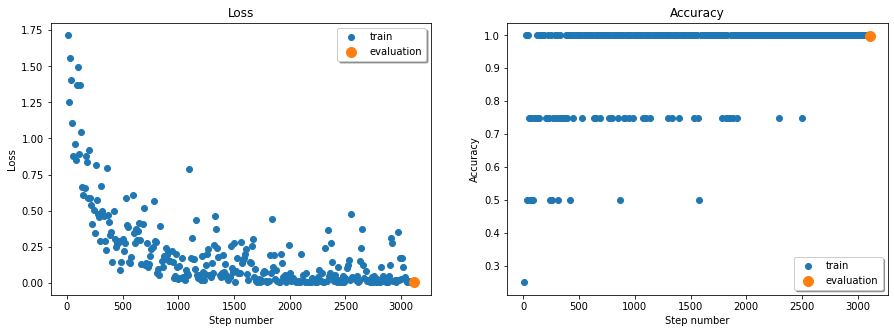

Loss last batch train:0.004346528090536594
Loss_evaluation:0.00331572409470103
Accuracy last batch train:1.0
Accuracy_evaluation:0.9979166666666667


In [41]:
train(model_energ, train_dataloader_energ, val_dataloader_energ, criterion ,optimizer, device, n_epochs, scheduler)

#Predict

In [42]:
def predict_test(model, test_dataloader, device='cuda:0'):
    model.eval()
    predictions = []
    for data in tqdm(test_dataloader):
        data = data.to(device)
        pred = torch.argmax(model(data))
        predictions.append(pred.item())
    return predictions

In [43]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, root=root, transform=None):

        self.data_dir = data_dir
        self.root = root
        self.transform = transform
        self.image_paths = [f'{root}{data_dir}/{path}'
                            for path in os.listdir(f'{root}{data_dir}')]
        self.ids = [path for path in os.listdir(f'{root}{data_dir}')]
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img
    def __len__(self):
        return len(self.image_paths)

In [44]:
transforms= torchvision.transforms.Compose([Resize(224),
                           ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ])

In [45]:
test = []
for i in tqdm(os.listdir('/content/drive/MyDrive/IDAO/idao_dataset/private_test/')):
  test.append(i)
for i in tqdm(os.listdir("/content/drive/MyDrive/IDAO/idao_dataset/public_test/")):
  test.append(i)

In [61]:
test1_dataset = TestDataset("drive/MyDrive/IDAO/idao_dataset/private_test/", transform=transforms)
test2_dataset = TestDataset("drive/MyDrive/IDAO/idao_dataset/public_test/", transform=transforms)
test_dataset = dataset_energ = ConcatDataset([test1_dataset,test2_dataset])
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=)

In [69]:
energ_pred = predict_test(model_energ,test_dataloader)

In [70]:
type_pred = predict_test(model,test_dataloader)

In [103]:
en = dict()
for i in range(len(class_df['energy1'])):
  en[class_df.iloc[i]['energy']] = class_df.iloc[i]['energy1']

In [104]:
df = pd.DataFrame(np.array(test), columns = ['id'])

In [105]:
df['id'] = [i[:-4] for i in df['id']]
df['classiﬁcation_predictions'] = type_pred
df['regression_predictions' ] = [en[i] for i in energ_pred]

In [106]:
df.set_index('id', inplace=True)
df

,classiﬁcation_predictions,regression_predictions
id,,
0002894871bb30af2670648c58b2506e9801a321,0,30
000a95ca23df016a149ff9af94b6e9d8633d6691,1,20
000b4407dee7dad2ba46586e6ba1264f45965e51,1,20
000c45d729066044e3dd3f885fddf013b845b6d7,0,30
0011f80e44faa713714ead6aeab3b2f9db54aebd,1,6
...,...,...
ff343a62752061d995f94ebc10ac53f79d1b5ab1,0,3
ff897755cb312cd6f510ba7a38cb293e648d97d5,0,3
ff9a93402457ac514cd069a7ce3f2e32692f5290,1,20


In [107]:
from google.colab import files
df.to_csv('submission.csv') 
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>